# 传统方法基线实验 (E1: HOG + SVM)

本notebook实现传统机器学习方法用于PlantDoc植物病害分类任务。

**实验目标**：
- E1: HOG特征 + SVM分类器（基线）
- 后续扩展：特征组合、分类器对比、消融实验

**数据来源**：使用 `data/splits/plantdoc_split_seed42.json` 保持与深度学习实验一致。


In [ ]:
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path("../src").resolve()))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import pickle
from datetime import datetime

# Import our modules
from data.traditional_loader import load_all_splits
from models.traditional_features import (
    extract_hog_features,
    extract_color_histogram,
    extract_lbp_features,
    combine_features,
)
from models.traditional_classifiers import (
    train_svm,
    train_logistic_regression,
    train_mlp,
    evaluate_model,
    save_model,
)
from eval.traditional_eval import (
    plot_confusion_matrix,
    plot_feature_comparison,
    visualize_hog_features,
)

# Setup
sns.set_style("whitegrid")
plt.rcParams["font.sans-serif"] = ["SimHei", "Arial Unicode MS", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

# Paths
DATA_DIR = Path("../data")
SPLIT_JSON = DATA_DIR / "splits" / "plantdoc_split_seed42.json"
PROCESSED_ROOT = DATA_DIR / "processed" / "plantdoc_224"
OUTPUTS_DIR = Path("../outputs")
FIGURES_DIR = OUTPUTS_DIR / "figures"
LOGS_DIR = OUTPUTS_DIR / "logs"
CHECKPOINTS_DIR = OUTPUTS_DIR / "checkpoints"

# Create directories
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
LOGS_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)

print("✓ Imports and paths configured")


✓ Imports and paths configured


## 1. 加载数据

使用统一的数据划分文件，加载训练集、验证集和测试集。


In [ ]:
# Load splits
splits_data, class_names = load_all_splits(
    split_json_path=SPLIT_JSON,
    processed_root=PROCESSED_ROOT,
    target_size=(256, 256),  # Resize to 256x256 for traditional features
    grayscale=False,  # Keep RGB for color features
)

X_train, y_train, train_paths = splits_data["train"]
X_val, y_val, val_paths = splits_data["val"]
X_test, y_test, test_paths = splits_data["test"]

print(f"Train: {X_train.shape}, labels: {y_train.shape}")
print(f"Val: {X_val.shape}, labels: {y_val.shape}")
print(f"Test: {X_test.shape}, labels: {y_test.shape}")
print(f"Number of classes: {len(class_names)}")
print(f"\nClass names (first 5): {class_names[:5]}")


Loading test: 100%|██████████| 398/398 [00:01<00:00, 302.52it/s]

Train: (1730, 256, 256, 3), labels: (1730,)
Val: (360, 256, 256, 3), labels: (360,)
Test: (398, 256, 256, 3), labels: (398,)
Number of classes: 27

Class names (first 5): ['Apple Scab Leaf', 'Corn Gray leaf spot', 'Potato leaf early blight', 'Potato leaf late blight', 'Squash Powdery mildew leaf']


## 2. 特征提取

### 2.1 HOG特征（基线）

HOG (Histogram of Oriented Gradients) 是传统方法中常用的特征，对形状和边缘信息敏感。


In [ ]:
print("Extracting HOG features...")
print("This may take a few minutes...")

# Extract HOG features
X_train_hog = extract_hog_features(
    X_train,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
)

X_val_hog = extract_hog_features(
    X_val,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
)

X_test_hog = extract_hog_features(
    X_test,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
)

print(f"HOG feature dimensions:")
print(f"  Train: {X_train_hog.shape}")
print(f"  Val: {X_val_hog.shape}")
print(f"  Test: {X_test_hog.shape}")


Extracting HOG features...
This may take a few minutes...
HOG feature dimensions:
  Train: (1730, 34596)
  Val: (360, 34596)
  Test: (398, 34596)


### 2.2 HOG特征可视化示例


Saved HOG visualization to ..\outputs\figures\hog_visualization_example.png


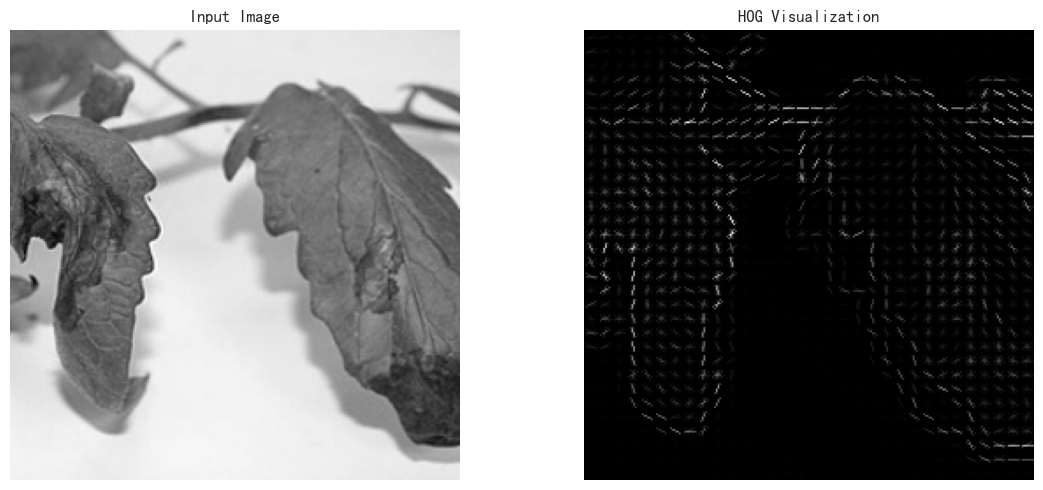

In [ ]:
# Visualize HOG for a random sample
sample_idx = np.random.randint(0, len(X_train))
sample_image = X_train[sample_idx]

visualize_hog_features(
    sample_image,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    save_path=FIGURES_DIR / "hog_visualization_example.png",
)


## 3. 训练SVM分类器（E1基线）

使用RBF核的SVM作为基线分类器。


In [ ]:
print("Training SVM with HOG features (E1 Baseline)...")
print("This may take several minutes...")

# Train SVM
svm_model = train_svm(
    X_train_hog,
    y_train,
    kernel="rbf",
    C=1.0,
    gamma="scale",
    class_weight="balanced",  # Handle class imbalance
    verbose=False,
)

print("✓ Training completed")


Training SVM with HOG features (E1 Baseline)...
This may take several minutes...
✓ Training completed


In [ ]:
# Evaluate on validation set
print("Validation Set Results:")
val_metrics = evaluate_model(svm_model, X_val_hog, y_val, class_names, verbose=True)


Validation Set Results:

Accuracy: 0.1833
Macro F1: 0.1372
Weighted F1: 0.1588

Classification Report:
                            precision    recall  f1-score   support

           Apple Scab Leaf       0.00      0.00      0.00        13
       Corn Gray leaf spot       0.14      0.11      0.12         9
  Potato leaf early blight       0.06      0.06      0.06        17
   Potato leaf late blight       0.04      0.20      0.07        15
Squash Powdery mildew leaf       0.25      0.89      0.39        19
  Tomato Early blight leaf       0.13      0.21      0.16        14
 Tomato Septoria leaf spot       0.14      0.15      0.15        20
                apple leaf       0.75      0.75      0.75        12
           apple rust leaf       0.20      0.08      0.12        12
          bell pepper leaf       0.00      0.00      0.00         8
     bell pepper leaf spot       0.00      0.00      0.00         9
            blueberry leaf       0.00      0.00      0.00        16
            

In [ ]:
# Evaluate on test set
print("\nTest Set Results:")
test_metrics = evaluate_model(svm_model, X_test_hog, y_test, class_names, verbose=True)



Test Set Results:

Accuracy: 0.2111
Macro F1: 0.1606
Weighted F1: 0.1855

Classification Report:
                            precision    recall  f1-score   support

           Apple Scab Leaf       0.00      0.00      0.00        14
       Corn Gray leaf spot       0.45      0.45      0.45        11
  Potato leaf early blight       0.00      0.00      0.00        18
   Potato leaf late blight       0.07      0.41      0.12        17
Squash Powdery mildew leaf       0.26      0.86      0.40        21
  Tomato Early blight leaf       0.19      0.27      0.22        15
 Tomato Septoria leaf spot       0.05      0.05      0.05        22
                apple leaf       0.67      0.29      0.40        14
           apple rust leaf       0.18      0.14      0.16        14
          bell pepper leaf       0.00      0.00      0.00         9
     bell pepper leaf spot       1.00      0.10      0.18        10
            blueberry leaf       0.00      0.00      0.00        17
               ch

## 4. 可视化结果

### 4.1 混淆矩阵


Saved confusion matrix to ..\outputs\figures\E1_hog_svm_confusion_matrix.png


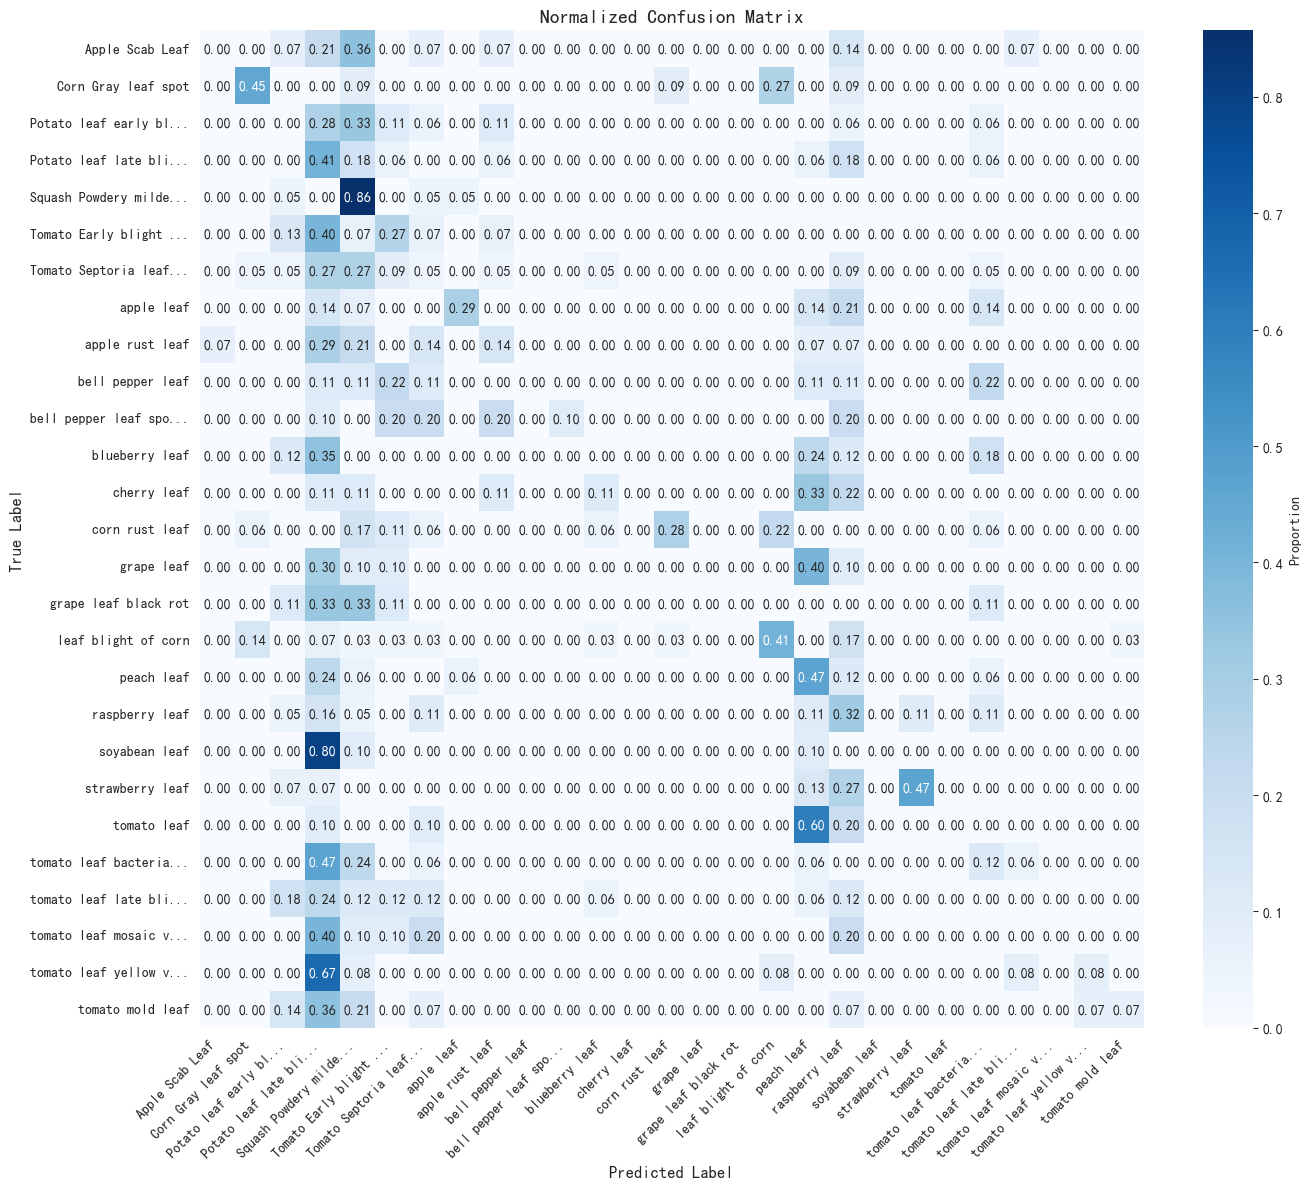

In [ ]:
# Plot confusion matrix for test set
plot_confusion_matrix(
    y_test,
    test_metrics["predictions"],
    class_names,
    save_path=FIGURES_DIR / "E1_hog_svm_confusion_matrix.png",
    normalize=True,
)


## 5. 保存结果

保存模型和实验结果供后续使用。


In [ ]:
# Save model
model_path = CHECKPOINTS_DIR / "E1_hog_svm_model.pkl"
save_model(svm_model, model_path)
print(f"Saved model to {model_path}")

# Save metrics to CSV
results_df = pd.DataFrame({
    "experiment": ["E1_HOG_SVM"],
    "val_accuracy": [val_metrics["accuracy"]],
    "val_macro_f1": [val_metrics["macro_f1"]],
    "test_accuracy": [test_metrics["accuracy"]],
    "test_macro_f1": [test_metrics["macro_f1"]],
    "test_weighted_f1": [test_metrics["weighted_f1"]],
    "timestamp": [datetime.now().strftime("%Y-%m-%d %H:%M:%S")],
})

results_csv = LOGS_DIR / "E1_hog_svm_results.csv"
results_df.to_csv(results_csv, index=False)
print(f"Saved results to {results_csv}")

# Display results
print("\n" + "="*60)
print("E1 Baseline Results Summary")
print("="*60)
print(f"Validation Accuracy: {val_metrics['accuracy']:.4f}")
print(f"Validation Macro F1: {val_metrics['macro_f1']:.4f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Test Macro F1: {test_metrics['macro_f1']:.4f}")
print(f"Test Weighted F1: {test_metrics['weighted_f1']:.4f}")
print("="*60)


Saved model to ..\outputs\checkpoints\E1_hog_svm_model.pkl
Saved results to ..\outputs\logs\E1_hog_svm_results.csv

E1 Baseline Results Summary
Validation Accuracy: 0.1833
Validation Macro F1: 0.1372
Test Accuracy: 0.2111
Test Macro F1: 0.1606
Test Weighted F1: 0.1855
